# 그래프 출력시 한글이 깨지지않게 함

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fc
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
fc-cache: invalid option -- 'c'
usage: fc-cache [-EfrsvVh] [-y SYSROOT] [--error-on-no-fonts] [--force|--really-force] [--sysroot=SYSROOT] [--system-only] [--verbose] [--version] [--help] [dirs]
Build font information caches in [dirs]
(all directories in font configuration by default).

  -E, --error-on-no-fonts  raise an error if no fonts in a directory
  -f, --force              scan directories with apparently valid caches
  -r, --really-force       erase all existing caches, then rescan
  -s, --system-only        scan system-wide directories only
  -y, --sysroot=SYSROOT    prepend SYSROOT to all paths for scanning
  -v, --verbose            display status information while busy
  -V, --version            display font config version and exit
  -h, --help               d

# 필요 패키지 import, 폰트 설치

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LinearRegression, Lasso, Ridge # 선형회귀, 선형회귀 바탕으로 만들어진 모델 : 라쏘, 릿지
from sklearn.neighbors import KNeighborsRegressor # KNN 회귀
from sklearn.tree import DecisionTreeRegressor # 의사결정회귀
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [12]:
plt.rc('font', family='NanumBarunGothic')

# 데이터 불러오기

In [13]:
df = pd.read_csv('fix_sale_final_ml_data.csv', encoding='utf-8')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   투자점수             902 non-null    float64
 1   고용인원             902 non-null    int64  
 2   투자유치횟수           902 non-null    int64  
 3   서비스/제품 수         902 non-null    int64  
 4   연간 퇴사율           902 non-null    int64  
 5   공동 창업자 수         902 non-null    int64  
 6   총 투자자 수          902 non-null    int64  
 7   특허기술 평균등급        902 non-null    float64
 8   최종투자단계           902 non-null    object 
 9   자본금(만원)          902 non-null    int64  
 10  누적투자유치금액(만원)     902 non-null    int64  
 11  연매출(만원)          902 non-null    int64  
 12  매출액_2020(만원)     902 non-null    int64  
 13  매출액_2021(만원)     902 non-null    int64  
 14  영업이익_2020(만원)    902 non-null    int64  
 15  영업이익_2021(만원)    902 non-null    int64  
 16  순이익_2020(만원)     902 non-null    int64  
 17  순이익_2021(만원)    

# 불필요한 컬럼 삭제 : 최종투자단계

In [15]:
df.drop('최종투자단계', axis = 1, inplace = True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   투자점수             902 non-null    float64
 1   고용인원             902 non-null    int64  
 2   투자유치횟수           902 non-null    int64  
 3   서비스/제품 수         902 non-null    int64  
 4   연간 퇴사율           902 non-null    int64  
 5   공동 창업자 수         902 non-null    int64  
 6   총 투자자 수          902 non-null    int64  
 7   특허기술 평균등급        902 non-null    float64
 8   자본금(만원)          902 non-null    int64  
 9   누적투자유치금액(만원)     902 non-null    int64  
 10  연매출(만원)          902 non-null    int64  
 11  매출액_2020(만원)     902 non-null    int64  
 12  매출액_2021(만원)     902 non-null    int64  
 13  영업이익_2020(만원)    902 non-null    int64  
 14  영업이익_2021(만원)    902 non-null    int64  
 15  순이익_2020(만원)     902 non-null    int64  
 16  순이익_2021(만원)     902 non-null    int64  
 17  자산_2020(만원)     

# 시각화로 데이터 파악 : 히스토그램

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


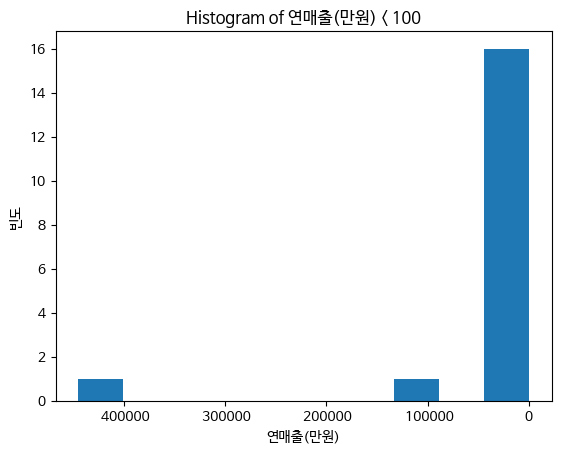

In [17]:
sales_data = df['연매출(만원)']

# 100보다 작은 값만 선택
sales_data_filtered = sales_data[sales_data < 100]

# Hist 생성
plt.hist(sales_data_filtered, bins = 10) # bins : 막대개수. 가로축 구간의 개수를 조정.

plt.title('Histogram of 연매출(만원) < 100')
plt.xlabel('연매출(만원)')
plt.ylabel('빈도')

plt.show()

In [18]:
# 연매출 0원 이상, 연매출 2500억원 미만인 데이터인스턴스만 남김

df = df[df['연매출(만원)'] > 0]

df = df[df['연매출(만원)'] < 25000000]

In [19]:
df['연매출(만원)']

0         22000
1        133000
2         19000
3         37000
4         58000
         ...   
896     1242000
897      283000
898      265000
899    13596000
901      341000
Name: 연매출(만원), Length: 866, dtype: int64

# machine learning

## 독립변수, 종속변수 나누기

In [20]:
X = df.drop(['연매출(만원)'], axis =1)
y = df['연매출(만원)']

## MinMax정규화

In [21]:
# y를 minmaxScale 공식으로 정규화함
s_y = ( ( y - y.min() ) / ( y.max() - y.min() ) )

## train, test용 데이터 나누기

In [22]:
train_X, test_X, train_y, test_y = train_test_split(X, s_y, random_state=42, test_size = 0.2)
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((692, 25), (174, 25), (692,), (174,))

## 훈련용 X 데이터로 fitting한 minmaxScaler로 train, test용 X데이터를 정규화함
좀 바보같은 말인거 같음

In [23]:
s = MinMaxScaler()
s.fit(train_X)
s_train_X = s.transform(train_X)
s_test_X = s.transform(test_X)

## 전반적 경향성 점수 확인 : import해온 다섯개의 모델을 활용

In [24]:
m = LinearRegression()
m1 = KNeighborsRegressor()
m2 = DecisionTreeRegressor()
m3 = Lasso()
m4 = Ridge()

for i in [m, m1, m2, m3, m4] :
  print(i, cross_val_score(i, s_train_X, train_y, cv=5).mean()) # cv : 교차 검증 fold수

LinearRegression() 0.9525642570381017
KNeighborsRegressor() 0.8052046535999893
DecisionTreeRegressor() 0.8743864902101277
Lasso() -0.0024155282838447256
Ridge() 0.9399258647207599


### 점수가 제일 잘 나온 모델(LinearRegression)로 학습시키고 점수를 낼거임



In [25]:
m.fit(s_train_X, train_y) # 학습
m.score(s_train_X, train_y), m.score(s_test_X, test_y) # 학습에 대한 점수

(0.9687076248474331, 0.9732955698855943)

## MSE 오차율(실제 정답값과 예측값의 차이) 검증 : 평균제곱오차

In [26]:
from sklearn.metrics import mean_squared_error

pre_train_y = m.predict(s_train_X)
pre_test_y = m.predict(s_test_X)

print(f"""train_data_score : {m.score(s_train_X, train_y)}, test_data_score : {m.score(s_test_X, test_y)}""")
print(f"""train_data_mse : {mean_squared_error(train_y, pre_train_y)}, test_data_mse : {mean_squared_error(test_y, pre_test_y)}""")

train_data_score : 0.9687076248474331, test_data_score : 0.9732955698855943
train_data_mse : 0.0007682467165147299, test_data_mse : 0.0003271862465843078


# 예측과 실제값 그래프화 : LinearRegression, Hist

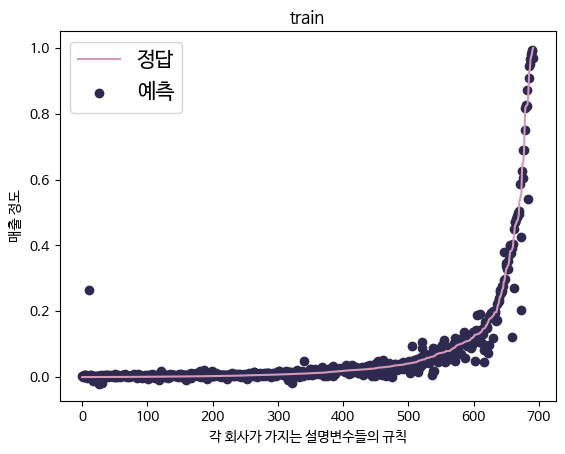

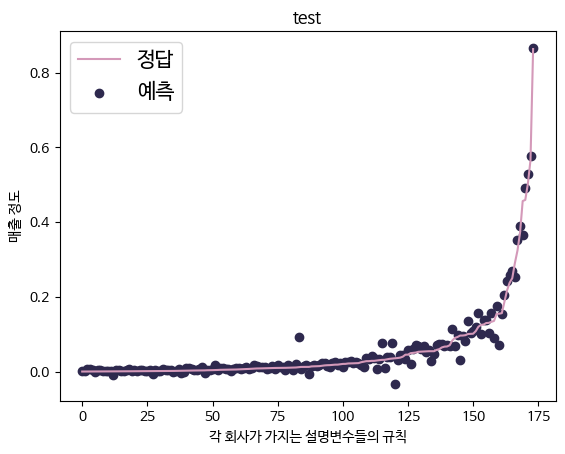

In [27]:
model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, s_y, test_size = 0.2, random_state = 42)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

y_train_pred = model.predict(X_train)

df_show = pd.DataFrame(np.concatenate([y_train.values.reshape(-1,1), y_train_pred.reshape(-1,1)], axis = 1), columns = ['y_train', 'y_train_pred']) # single Column일때 reshape(-1,) 을 사용
df_show = df_show.sort_values(by = 'y_train').reset_index(drop=True)

plt.plot(df_show['y_train'], color = '#D499B9', label='정답')
plt.scatter(df_show.index, df_show['y_train_pred'], color = '#2E294E', label = '예측')
#
plt.title('train')
plt.xlabel('각 회사가 가지는 설명변수들의 규칙')
plt.ylabel('매출 정도')
#
plt.legend(fontsize = 15)
plt.show()

df_show = pd.DataFrame(np.concatenate([y_test.values.reshape(-1,1), y_test_pred.reshape(-1,1)], axis = 1), columns = ['y_test', 'y_test_pred'])
df_show = df_show.sort_values(by = 'y_test').reset_index(drop=True)

plt.plot(df_show['y_test'], color = '#D499B9', label='정답')
plt.scatter(df_show.index, df_show['y_test_pred'], color = '#2E294E', label='예측')
#
plt.title('test')
plt.xlabel('각 회사가 가지는 설명변수들의 규칙')
plt.ylabel('매출 정도')
#
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

## 피쳐 몇개 제거 후 경향성 파악

In [28]:
X = df.drop(['연매출(만원)', '공동 창업자 수','특허기술 평균등급'], axis = 1)
y = df['연매출(만원)']

In [29]:
s_y = (( y - y.min() ) / ( y.max() - y.min() ))

In [30]:
train_X, test_X, train_y, test_y = train_test_split( X, s_y, random_state = 42, test_size = 0.3 )
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((606, 23), (260, 23), (606,), (260,))

In [31]:
s = MinMaxScaler()
s.fit(train_X)
s_train_X = s.transform(train_X)
s_test_X = s.transform(test_X)

In [32]:
m = LinearRegression()
m1 = KNeighborsRegressor()
m2 = DecisionTreeRegressor()
m3 = Lasso()
m4 = Ridge()

for i in [m, m1, m2, m3, m4] :
  print(i, cross_val_score(i, s_train_X, train_y, cv=5).mean())

LinearRegression() 0.948764132427519
KNeighborsRegressor() 0.8062571453707207
DecisionTreeRegressor() 0.9132707596935248
Lasso() -0.006090254127175676
Ridge() 0.9371663615532289


In [33]:
m.fit(s_train_X, train_y)
m.score(s_train_X, train_y), m.score(s_test_X, test_y)

(0.9713966384439778, 0.9594010168806175)

In [34]:
from sklearn.metrics import mean_squared_error

pre_train_y = m.predict(s_train_X)
pre_test_y = m.predict(s_test_X)

print(f'''train_data_score : { m.score(s_train_X, train_y) }, test_data_score : {m.score(s_test_X, test_y)}''') ##
print(f'''train_data_mse : { mean_squared_error(train_y, pre_train_y) }, test_data_mse : {mean_squared_error(test_y, pre_test_y)}''') ##

train_data_score : 0.9713966384439778, test_data_score : 0.9594010168806175
train_data_mse : 0.0007248210881950392, test_data_mse : 0.0005862284243861479


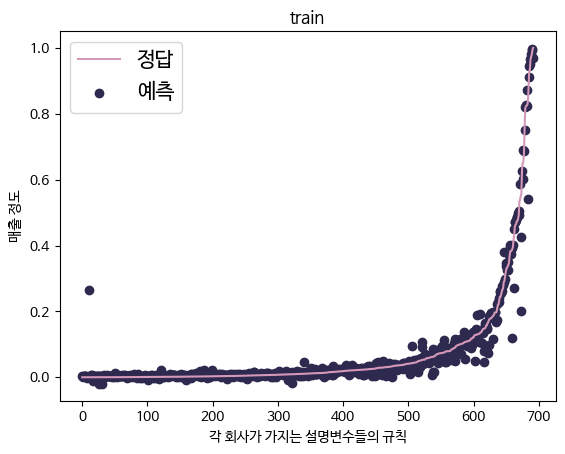

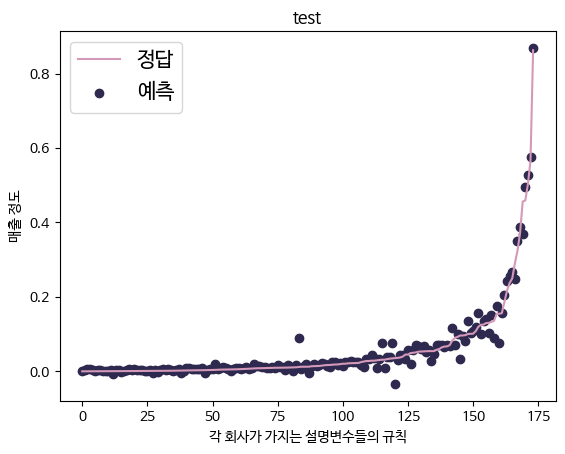

In [35]:
model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, s_y, test_size = 0.2, random_state = 42)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

y_train_pred = model.predict(X_train)

df_show = pd.DataFrame(np.concatenate([y_train.values.reshape(-1,1), y_train_pred.reshape(-1,1)], axis = 1), columns = ['y_train', 'y_train_pred'])
df_show = df_show.sort_values(by = 'y_train').reset_index(drop=True)

plt.plot(df_show['y_train'], color = '#D499B9', label='정답')
plt.scatter(df_show.index, df_show['y_train_pred'], color = '#2E294E', label='예측')
#
plt.title('train')
plt.xlabel('각 회사가 가지는 설명변수들의 규칙')
plt.ylabel('매출 정도')
#
plt.legend(fontsize = 15)
plt.show()

df_show = pd.DataFrame(np.concatenate([y_test.values.reshape(-1,1), y_test_pred.reshape(-1,1)], axis = 1), columns = ['y_test', 'y_test_pred'])
df_show = df_show.sort_values(by = 'y_test').reset_index(drop=True)

plt.plot(df_show['y_test'], color = '#D499B9', label='정답')
plt.scatter(df_show.index, df_show['y_test_pred'], color = '#2E294E', label='예측')
#
plt.title('test')
plt.xlabel('각 회사가 가지는 설명변수들의 규칙')
plt.ylabel('매출 정도')
#
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()